# Mollow triplets

In [1]:
from functools import partial
import pdb

import pickle
import numpy as np
from scipy.fftpack import fft
from scipy.integrate import quad
import matplotlib.pyplot as plt

import pysme.integrate as integ
import pysme.hierarchy as hier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [4]:
plt.style.use('paper.mplstyle')

A coherent drive adds a Hamiltonian term.
\begin{align}
    d\rho&=dt[\beta^*L-\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    &=-idt[i\beta^*L-i\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    H_{\text{eff}}&=i\beta^*L-i\beta L^\dagger
\end{align}
Rabi frequency $\Omega=2|\beta|$. Carmichæl notates the Rabi frequency as $2\Omega$, so $\Omega=|\beta|$.

In [5]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

In [6]:
def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [7]:
quad(lambda t: xi_rect(t, a=0, b=2)**2, -1, 3)

In [58]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def Heff_fn(beta, L):
    return 1.j*np.conj(beta)*L - 1.j*beta*L.conj().T

def calc_hier_auto_corr(xi_fn, L, r, mu, beta, gamma, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                        solve_ivp_kwargs=None):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, np.sqrt(gamma) * L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, vac_rho(m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

def calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus, solve_ivp_kwargs=None):
    N = np.sinh(r)**2
    M_sq = -np.exp(2.j * mu) * np.sinh(r) * np.cosh(r)
    integrator = integ.UncondGaussIntegrator(np.sqrt(gamma)*L, M_sq, N, Heff_fn(beta, L))
    soln_ss = integrator.integrate(Id/2, times_ss)

    #pdb.set_trace()

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    #pdb.set_trace()

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    #pdb.set_trace()

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)

    #pdb.set_trace()
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

def calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus):
    N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(
        Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, solve_ivp_kwargs=None)
    integrator = integ.QuasiMarkoff2LvlIntegrator(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

In [9]:
def plot_emission_spectra(auto_corrs, labels, Rabi_offset, kwargs_plots=None, width=50, ax=None, figsize=(10,3), broadband=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return_fig = True
    else:
        return_fig = False
    if kwargs_plots is None:
        kwargs_plots = it.repeat({}, len(auto_corrs))
    for auto_corr, label, kwargs in zip(auto_corrs, labels, kwargs_plots):
        ywf = fft(auto_corr.real)
        ax.plot(np.abs(np.hstack([ywf[-width:], ywf[:width]])), label=label, **kwargs)
    ax.legend()
    ax.set_xticks([width - Rabi_offset, width, width + Rabi_offset])
    ax.set_xticklabels([r'$\omega_c-\Omega$', r'$\omega_c$', r'$\omega_c+\Omega$'])
    ax.set_yticks([])
    ax.set_ylim(0, None)
    ax.set_ylabel(r'$S(\omega)$')
    ax.set_xlabel(r'$\omega$')
    return (fig, ax) if return_fig else None

In [10]:
def lam_mu(gamma_c, eps):
    lam = gamma_c + eps
    mu = gamma_c - eps
    return lam, mu

def N_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               - 1/((omega - omega_A)**2 + lam**2))
    
def mod_M_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               + 1/((omega - omega_A)**2 + lam**2))

def deltas_degen_PA(gamma_c, Omega, lam, mu):
    delta_mu = gamma_c*Omega*(lam**2 - mu**2)/(4*mu*(Omega**2 + mu**2))
    delta_lam = gamma_c*Omega*(lam**2 - mu**2)/(4*lam*(Omega**2 + mu**2))
    return delta_mu, delta_lam

def F_G(delta_mu, delta_lam, Phi):
    F_A = -(1j/4)*(delta_mu*(1 + np.cos(Phi))
                   - delta_lam*(1 - np.cos(Phi)))
    G_A = -(1/4)*(delta_mu + delta_lam)*np.sin(Phi)
    return F_A, G_A

def get_degen_PA_params(Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s):
    lam, mu = lam_mu(gamma_c, eps)
    N_A = N_degen_PA(omega_A, omega_A, lam, mu)
    N_Om = N_degen_PA(omega_A + Omega, omega_A, lam, mu)
    mod_M_A = mod_M_degen_PA(omega_A, omega_A, lam, mu)
    mod_M_Om = mod_M_degen_PA(omega_A + Omega, omega_A, lam, mu)
    M_A = np.exp(2j*phi_s)*mod_M_A
    M_Om = np.exp(2j*phi_s)*mod_M_Om
    Delta_AL = omega_A - omega_L
    Phi = 2*phi_L - phi_s
    delta_mu, delta_lam = deltas_degen_PA(gamma_c, Omega, lam, mu)
    F_A, G_A = F_G(delta_mu, delta_lam, Phi)
    return N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A

In [11]:
rho0 = (Id - sz) / 2
S = Id
L = sm
H = zero

In [21]:
gamma = 0.5
beta = 4.j
T = 2**10
width = 2*T
taus = np.linspace(0, T, 2**14)
times_ss = np.linspace(0, 32, 2**12)
d_omega = 2*np.pi / T
Rabi_offset = 2*np.abs(beta) // d_omega

In [17]:
rho_ss_coh, delta_Expt_t_taus_coh = calc_white_auto_corr(L, gamma, beta, 0, 0, times_ss, taus,
                                                         solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

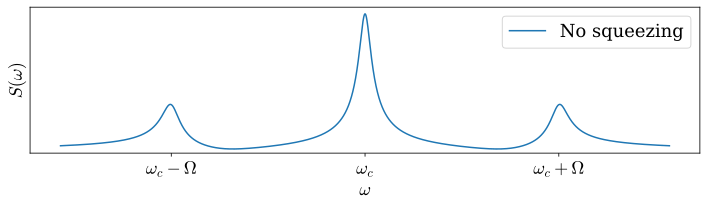

In [22]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh], ['No squeezing'], Rabi_offset, width=width)
plt.tight_layout()

In [23]:
r = np.log(2)
mu = 0
rho_ss_sq, delta_Expt_t_taus_sq = calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus,
                                                       solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

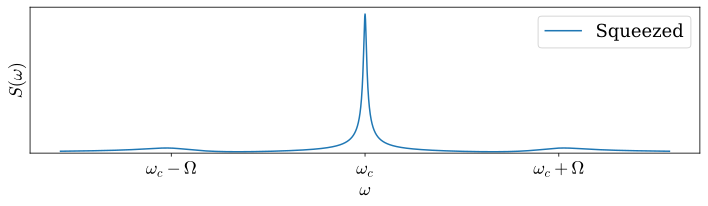

In [24]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_sq], ['Squeezed'], Rabi_offset, width=width)
plt.tight_layout()

In [25]:
r = np.log(2)
mu = np.pi/2
rho_ss_antisq, delta_Expt_t_taus_antisq = calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus,
                                                               solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

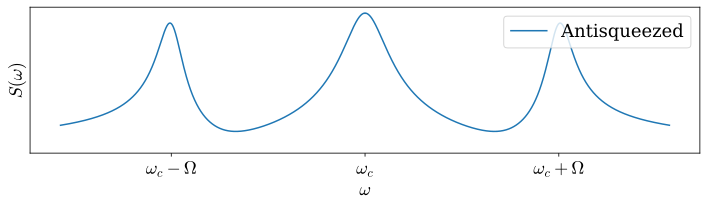

In [27]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_antisq], ['Antisqueezed'], Rabi_offset, width=width)
plt.tight_layout()

In [28]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
omega_A = 0
omega_L = 0
gamma_c = 1
eps = 0.5
phi_s = 0
rho_ss_qm, delta_Expt_t_taus_qm = calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

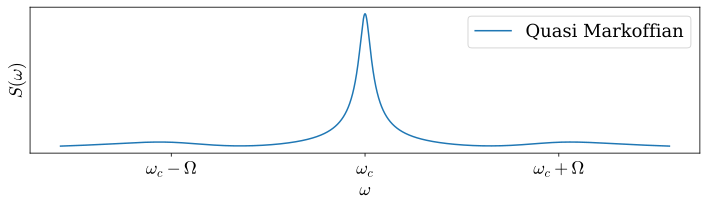

In [30]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_qm], ['Quasi Markoffian'], Rabi_offset, width=width)
plt.tight_layout()

In [65]:
def savex(obj, fname):
    try:
        with open(fname, 'xb') as f:
            pickle.dump(obj, f)
    except FileExistsError:
        print('Data already exist.')

In [31]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
omega_A = 0
omega_L = 0
gamma_c = 1
eps = 0.5
phi_s = np.pi/2
rho_ss_qm_anti, delta_Expt_t_taus_qm_anti = calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

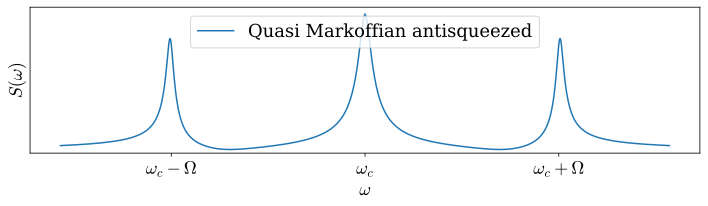

In [32]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_qm_anti], ['Quasi Markoffian antisqueezed'], Rabi_offset, width=width)
plt.tight_layout()

In [36]:
%%time
r = np.log(2)
mu = 0
m_max = 12
Expt_t_taus_wavepacket = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                             L, r, mu, beta, gamma, m_max,
                                             taus, rho_ss_coh, t=0.5,
                                             solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

CPU times: user 16min 50s, sys: 2min 3s, total: 18min 54s
Wall time: 4min 50s


In [69]:
savex(Expt_t_taus_wavepacket, 'Expt_t_taus_wavepacket.pickle')

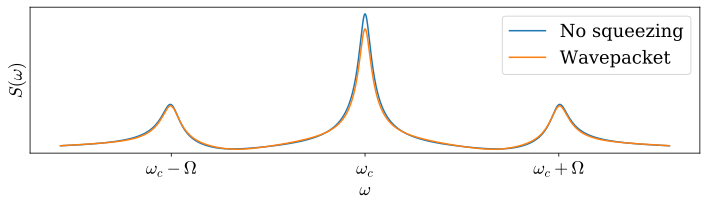

In [37]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket[0]],
                                ['No squeezing',
                                 'Wavepacket'],
                                Rabi_offset, width=width)
plt.tight_layout()

In [38]:
%%time
r = np.log(2)
mu = 0
m_max = 12
Expt_t_taus_wavepacket_075 = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                 L, r, mu, beta, gamma, m_max,
                                                 taus, rho_ss_coh, t=0.75,
                                                 solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

CPU times: user 16min 47s, sys: 1min 50s, total: 18min 38s
Wall time: 4min 42s


In [67]:
savex(Expt_t_taus_wavepacket_075, 'Expt_t_taus_wavepacket_075.pickle')

Data already exist.


In [39]:
%%time
r = np.log(2)
mu = 0
m_max = 12
Expt_t_taus_wavepacket_025 = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                 L, r, mu, beta, gamma, m_max,
                                                 taus, rho_ss_coh, t=0.25,
                                                 solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

CPU times: user 17min 51s, sys: 1min 54s, total: 19min 46s
Wall time: 4min 59s


In [68]:
savex(Expt_t_taus_wavepacket_025, 'Expt_t_taus_wavepacket_025.pickle')

In [42]:
%%time
r = np.log(2)
mu = 0
m_max = 12
Expt_t_taus_wavepacket_100 = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                 L, r, mu, beta, gamma, m_max,
                                                 taus, rho_ss_coh, t=1,
                                                 solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

CPU times: user 17min 4s, sys: 1min 40s, total: 18min 44s
Wall time: 4min 44s


In [70]:
savex(Expt_t_taus_wavepacket_100, 'Expt_t_taus_wavepacket_100.pickle')

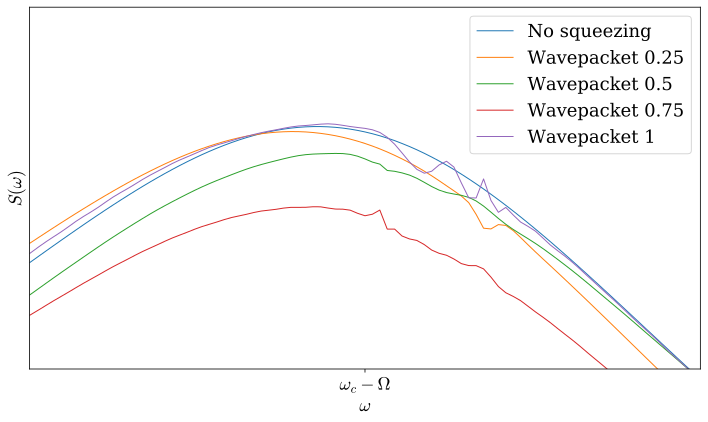

In [57]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket_025[0],
                                 Expt_t_taus_wavepacket[0],
                                 Expt_t_taus_wavepacket_075[0],
                                 Expt_t_taus_wavepacket_100[0]],
                                ['No squeezing',
                                 'Wavepacket 0.25',
                                 'Wavepacket 0.5',
                                 'Wavepacket 0.75',
                                 'Wavepacket 1'],
                                Rabi_offset, width=width,
                                kwargs_plots=it.repeat({'linewidth': 1}),
                                figsize=(10, 6))
ax.set_xlim(width - Rabi_offset - np.sqrt(width), width - Rabi_offset + np.sqrt(width))
ax.set_ylim(ax.get_ylim()[1]/4, 3*ax.get_ylim()[1]/8)
plt.tight_layout()

In [59]:
%%time
r = np.log(2)
mu = 0
m_max = 12
Expt_t_taus_wavepacket_100_tol = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                 L, r, mu, beta, gamma, m_max,
                                                 taus, rho_ss_coh, t=1,
                                                 solve_ivp_kwargs={'rtol': 1e-9, 'atol': 1e-12})

CPU times: user 17min 8s, sys: 1min 35s, total: 18min 43s
Wall time: 4min 43s


In [71]:
savex(Expt_t_taus_wavepacket_100_tol, 'Expt_t_taus_wavepacket_100_tol.pickle')

In [61]:
%%time
r = np.log(2)
mu = 0
m_max = 13
Expt_t_taus_wavepacket_100_m_13 = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                 L, r, mu, beta, gamma, m_max,
                                                 taus, rho_ss_coh, t=1,
                                                 solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

CPU times: user 25min 53s, sys: 3min 26s, total: 29min 20s
Wall time: 7min 24s


In [72]:
savex(Expt_t_taus_wavepacket_100_m_13, 'Expt_t_taus_wavepacket_100_m_13.pickle')

In [63]:
%%time
r = np.log(2)
mu = 0
m_max = 14
Expt_t_taus_wavepacket_100_m_14 = calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                 L, r, mu, beta, gamma, m_max,
                                                 taus, rho_ss_coh, t=1,
                                                 solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

CPU times: user 28min 39s, sys: 3min 55s, total: 32min 35s
Wall time: 8min 17s


In [73]:
savex(Expt_t_taus_wavepacket_100_m_14, 'Expt_t_taus_wavepacket_100_m_14.pickle')

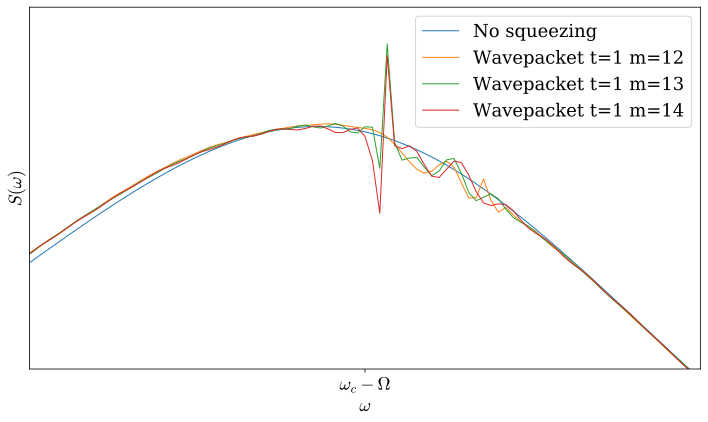

In [64]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket_100[0],
                                 Expt_t_taus_wavepacket_100_m_13[0],
                                 Expt_t_taus_wavepacket_100_m_14[0]],
                                ['No squeezing',
                                 'Wavepacket t=1 m=12',
                                 'Wavepacket t=1 m=13',
                                 'Wavepacket t=1 m=14'],
                                Rabi_offset, width=width,
                                kwargs_plots=it.repeat({'linewidth': 1}),
                                figsize=(10, 6))
ax.set_xlim(width - Rabi_offset - np.sqrt(width), width - Rabi_offset + np.sqrt(width))
ax.set_ylim(ax.get_ylim()[1]/4, 3*ax.get_ylim()[1]/8)
plt.tight_layout()